# Identifying features linked to attractiveness
This notebook follows on this other notebook on analysing facial ratings. The previous notebook aimed to analyse how people rate a face ; we examined 
- the distribution of averages ratings across multiple pictures
- how several variables (gender and ethnicity) correlate with the ratings
- how individual raters rate different faces
- how different people rate a same face

The above analysis was performed only on the numerical ratings given by raters to each image as well as some covariates (gender and ethnicity). For now we have not yet used the pictures themselves. In the present notebook we aim to determine which features of the images are correlated with the ratings. In a nutshell we want to find out if we can isolate:
- specific features or at least some projection from the pictures, that are characteristic of attractiveness
- specific features or at least some projection from the pictures, that are characteristic of unattractiveness

# Loading Data
First let's load the ratings and the path for each image

In [11]:


import os
from pathlib import Path
from PIL import Image
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.preprocessing import StandardScaler


In [2]:

link_data = "https://github.com/fbplab/MEBeauty-database/raw/main/scores/generic_scores_all_2022.xlsx"
df = pd.read_excel(link_data)
df = df.iloc[:, 0:3] #remove individual ratings
df

,mean,image,path
0,1.117647,kuma-kum-GKbPbR0ZAT4-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...
1,1.000000,pexels-cottonbro-5529905.jpg,/home/ubuntu/ME-beautydatabase/images/male/asi...
2,1.000000,pexels-nishant-aneja-2561432.jpg,/home/ubuntu/ME-beautydatabase/images/male/ind...
3,1.428571,woman-1929550_1920.jpg,NaN
4,1.500000,pexels-himesh-mehta-3059930.jpg,/home/ubuntu/ME-beautydatabase/images/female/i...
...,...,...,...
2602,9.000000,pexels-pixabay-247322.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...
2603,9.375000,women-5930352_1920.jpg,/home/ubuntu/ME-beautydatabase/images/female/a...
2604,9.222222,francesca-zama-1fhl_kmbfAE-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/h...
2605,9.625000,sofia--LNdco1UgNY-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...


In [3]:
df.iloc[4,2]

'/home/ubuntu/ME-beautydatabase/images/female/indian/pexels-himesh-mehta-3059930.jpg'

In [4]:
# Drop  missing values if any
df.dropna(inplace=True)
df.drop("image", axis=1, inplace=True)

def standardize_path(cell):
    # We only want the architecture of the path from {gender}.
    # That way later we can provide whatever root path we want for the dataset
    path = Path(cell)
    return "/".join(path.parts[-3:])

df["path"] = df["path"].apply(standardize_path)

In [5]:
df

,mean,path
0,1.117647,female/caucasian/kuma-kum-GKbPbR0ZAT4-unsplash...
1,1.000000,male/asian/pexels-cottonbro-5529905.jpg
2,1.000000,male/indian/pexels-nishant-aneja-2561432.jpg
4,1.500000,female/indian/pexels-himesh-mehta-3059930.jpg
5,1.888889,male/asian/pexels-kaniseeyapose-2751061.jpg
...,...,...
2602,9.000000,female/caucasian/pexels-pixabay-247322.jpg
2603,9.375000,female/asian/women-5930352_1920.jpg
2604,9.222222,female/hispanic/francesca-zama-1fhl_kmbfAE-uns...
2605,9.625000,female/caucasian/sofia--LNdco1UgNY-unsplash.jpg


After removing the missing values, we have 2553 images. That's a lot of pictures ! Let's download them locally so that we can load them more easily later. You may take a cup of tea, this may take a while. Note that you may also only download the cropped dataset which is faster and takes less space on the machine.

In [6]:
import os
import requests
from tqdm import tqdm



# Function to download a file from a URL
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

def download_dataset(df, dataset_url, output_dir, rewrite=False):
    
    image_paths = df['path'].tolist()
    with tqdm(total=len(image_paths), unit='file') as pbar:
        for  path in image_paths:
            local_path = os.path.join(output_dir, path)
            if  rewrite or not os.path.isfile(local_path):
                write_dir = os.path.join(output_dir, *Path(path).parts[:-1])
                #print(write_dir)
                os.makedirs(write_dir, exist_ok=True)
                download_file(os.path.join(dataset_url , path), local_path)
            pbar.update(1)



In [7]:

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

download_dataset(df, base_url_original, 'images/original', rewrite=False)

100%|██████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 6479.67file/s]


In [28]:
download_dataset(df, base_url_cropped, 'images/cropped', rewrite=False)

100%|████████████████████████████████████████████████████████████████████████████| 2553/2553 [25:45<00:00,  1.65file/s]


Let's have a look at the images. We will define a function to load and display a group of pictures

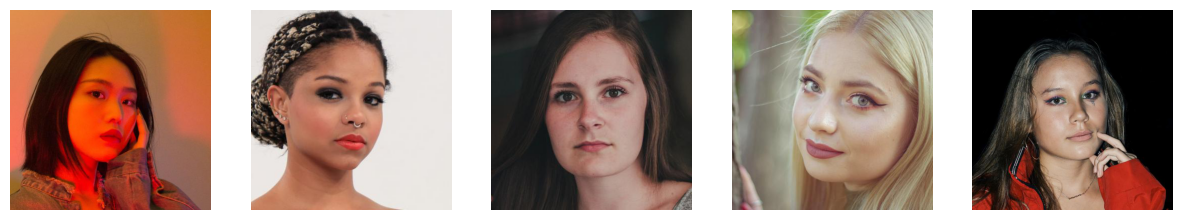

In [26]:


# Function to load images
def load_images(dir:str, num_images:int=5)->list:
    '''
     loads a set number of random images within the directory 
    '''
    
    img_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_paths = []
    assert os.path.isdir(dir)
    for root, dirs, files in os.walk(dir):
        for fname in files:
            if any(fname.lower().endswith(ext) for ext in img_exts):
                image_paths.append(os.path.join(root, fname))
    
    # Select a random subset of image paths
    num_images = min(num_images, len(image_paths))
                     
    selected_paths = random.sample(image_paths, num_images)
    images= []
    for image_path in selected_paths:
        image = Image.open(image_path).convert('RGB')
        images.append(image)
    
    return images

# Function to display images
def display_images(images):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
    plt.show()


# Load a few  images of women
images_dir = 'images/original/female'
images = load_images(images_dir, num_images=5)

display_images(images)

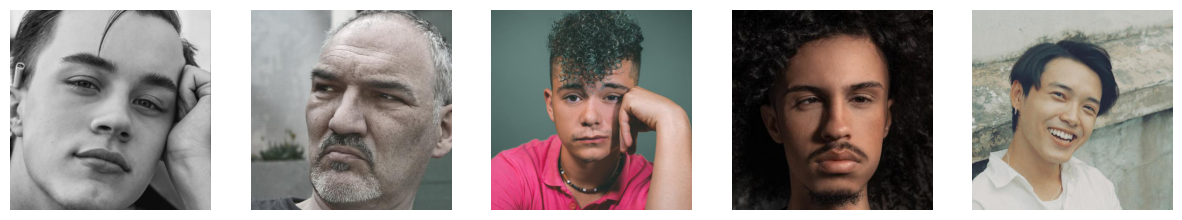

In [27]:
# Load a few  images of men
images_dir = 'images/original/male'
images = load_images(images_dir, num_images=5)

display_images(images)

Some of the images may be corrupted. Let's get rid of them before they cause us any problem downstream. It's ok, we have lots of them.

In [38]:
def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, indeed an image
        return True
    except (IOError, SyntaxError) as e:
        print(f'Bad file: {image_path}')
        return False

def filter_corrupted_images(df, images_dir):
    df['full_path'] = df['path'].apply(lambda p: os.path.join(images_dir, p))
    df['is_valid'] = df['full_path'].apply(is_image_loadable)
    df_cleaned = df[df['is_valid']].drop(columns=['full_path', 'is_valid']).reset_index(drop=True)
    return df_cleaned


# Assuming your dataframe is named 'df' and the base path to your images is 'images_dir'
images_dir = 'images/original'
df_cleaned = filter_corrupted_images(df, images_dir )

# Check the number of images that were successfully loaded
print(f'Number of valid images: {len(df_cleaned)}')
print(f'Number of corrupted images removed: {len(df) - len(df_cleaned)}')

df = df_cleaned


Bad file: images/original\male/indian/puvvukonvict-photography-AtpSEe3yoIg-unsplash.jpg
Bad file: images/original\male/mideastern/imad-clicks-2_qmEnz7bQ4-unsplash.jpg
Bad file: images/original\female/indian/shifaaz-shamoon-MqLy-G-dBi8-unsplash.jpg
Bad file: images/original\male/black/payton-tuttle-n_RdRxH_7h4-unsplash.jpg
Bad file: images/original\male/hispanic/aryo-lahap-ZVc4Zg4TY8s-unsplash.jpg
Bad file: images/original\female/caucasian/brunette-2478405_1920.jpg
Bad file: images/original\male/caucasian/boy-1105361_1920.jpg
Bad file: images/original\male/caucasian/business-man-1385050_1920.jpg
Bad file: images/original\male/asian/tanjir-ahmed-chowdhury-YMJvX8k3Kfc-unsplash.jpg
Bad file: images/original\female/caucasian/creating-a-brand-WxAOdbDpMiU-unsplash.jpg
Bad file: images/original\male/caucasian/man-1488305_1920.jpg
Bad file: images/original\female/asian/pexels-rodnae-productions-4911184.jpg
Bad file: images/original\female/indian/brown-4197806_1920.jpg
Bad file: images/original\

## Feature extraction
Now, since we are interested in extracting features from images, it comes to that an optimal tool for that are convolutional neural network (CNNs). This class of deep learning models  is particularly well-suited for image-related tasks due to their ability to automatically and hierarchically learn spatial hierarchies of features. In the context of identifying features linked to different levels of attractiveness, CNNs like MobileNet are especially advantageous because they can capture complex patterns and textures in images that are often crucial for subjective assessments such as attractiveness. This type of model is able to identify subtle nuances in facial features, skin texture, and other visual attributes that might correlate with perceived attractiveness.

By leveraging a pre-trained model like MobileNetV2, which have been trained on large datasets such as ImageNet (which includes among others a tremendous amount of face images), we benefit the model's prior knowledge can be adapted to our specific task. We chose MobileNetV2 since it offers a good balance between performance and computational efficiency. We will use the representation of each image given by the model to have rich high-level  features for each image. We then will be able to analyse those features. Since we only really want the learned features, we remove the last layer (classification layer)

In [30]:


# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval()



D:\Utilisateurs\souma\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\souma/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 36.2MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [39]:


# Function to extract features using MobileNetV2
def extract_features(image_tensor):
    with torch.no_grad():
        features = model(image_tensor.unsqueeze(0))
    return features.flatten().numpy()

def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.flatten().numpy()
    
images_dir = "images/original"
image_paths = df["path"]
features = np.array([extract_features(os.path.join(images_dir, path)) for path in image_paths])
ratings = df["mean"].to_numpy()
features.shape, ratings.shape

((2523, 62720), (2523,))

In [ ]:


# Load ratings data
ratings = pd.read_csv('path/to/your/ratings.csv')

# Ensure the paths match the preprocessed images
ratings['path'] = ratings['image'].apply(lambda x: os.path.join(output_dir, x))

# Function to extract features for all images and combine with ratings
def create_features_df(ratings, output_dir):
    features = []
    for path in tqdm(ratings['path']):
        if os.path.isfile(path):
            image_tensor = torch.load(path)
            features.append(extract_features(image_tensor))
        else:
            features.append([None] * 4096)  # Assuming VGG16 feature vector size is 4096

    features_df = pd.DataFrame(features)
    features_df['mean'] = ratings['mean'].values
    return features_df

# Create features DataFrame
features_df = create_features_df(ratings, output_dir)

# Display the features DataFrame
print(features_df.head())
